In [4]:
!pip install fastai==1.0.42

You are using pip version 18.1, however version 21.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [6]:
torch.cuda.is_available()
torch.backends.cudnn.enabled

Make sure cuda is installed: True
Make sure cudnn is enabled: True


In [7]:
base_image_dir = '../input/aptos2019-blindness-detection/train_images/'
df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df.columns = ['image', 'level']
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.png'.format(x)))
df['exists'] = df['path'].map(os.path.exists) #Most of the files do not exist because this is a sample of the original dataset
df = df[df['exists']]
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(10)

,level,path
0,1,../input/aptos2019-blindness-detection/train_i...
1,4,../input/aptos2019-blindness-detection/train_i...
2,1,../input/aptos2019-blindness-detection/train_i...
3,0,../input/aptos2019-blindness-detection/train_i...
4,0,../input/aptos2019-blindness-detection/train_i...
5,0,../input/aptos2019-blindness-detection/train_i...
6,2,../input/aptos2019-blindness-detection/train_i...
7,1,../input/aptos2019-blindness-detection/train_i...
8,4,../input/aptos2019-blindness-detection/train_i...
9,0,../input/aptos2019-blindness-detection/train_i...


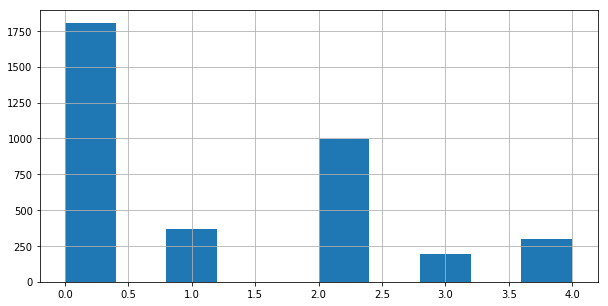

In [8]:
df['level'].hist(figsize = (10, 5))

In [9]:
df.pivot_table(index='level', aggfunc=len)

,path
level,
0,1805
1,370
2,999
3,193
4,295


In [10]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

In [11]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set

733

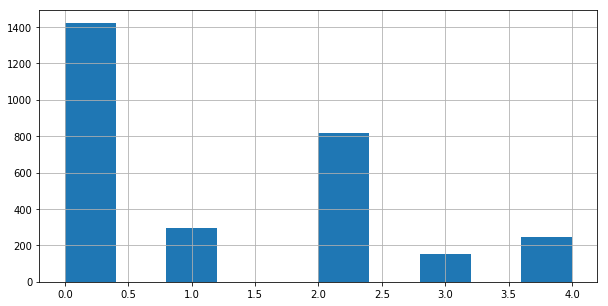

In [12]:
train_df['level'].hist(figsize = (10, 5))
len(val_df)

In [13]:
train_df.pivot_table(index='level', aggfunc=len)

,path
level,
0,1422
1,296
2,817
3,150
4,244


New Data Size: 7110 Old Size: 2929


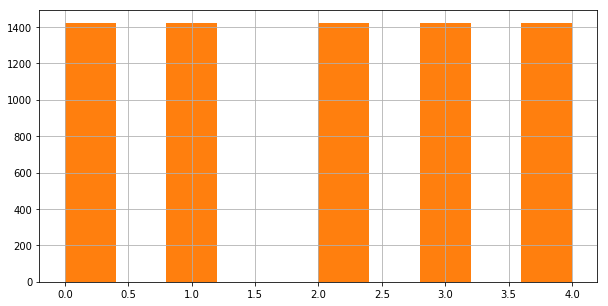

In [14]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [15]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)

7843

In [16]:
from PIL import Image

im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height) 

2588 1958


In [17]:
bs = 16 #smaller batch size is better for training, but may take longer
sz=224

In [18]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
src = (ImageItemList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_idx(range(len(train_df)-1,len(df))) #Splitting the dataset
        .label_from_df(cols='level') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz) #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

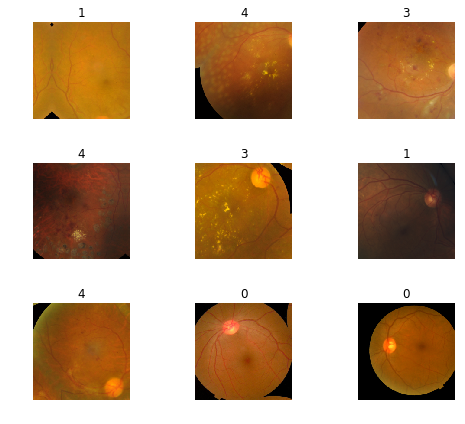

In [19]:
data.show_batch(rows=3, figsize=(7,6))

In [20]:
print(data.classes)
len(data.classes),data.c

[0, 1, 2, 3, 4]


(5, 5)

In [21]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.argmax(y_hat,1), y, weights='quadratic'),device='cuda:0')

In [22]:
import torchvision
learn = create_cnn(data, models.resnet50, metrics = [accuracy,quadratic_kappa])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 86875774.08it/s]


In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


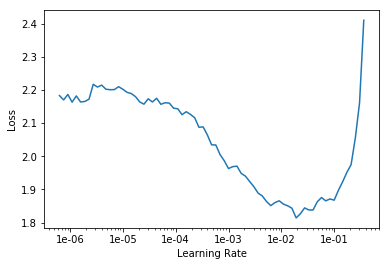

In [24]:
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(4,max_lr = 2e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,1.014571,0.729853,0.707084,0.774038
2,0.817177,0.660635,0.723433,0.806894
3,0.703889,0.468036,0.821526,0.896305
4,0.597205,0.456527,0.817439,0.893564


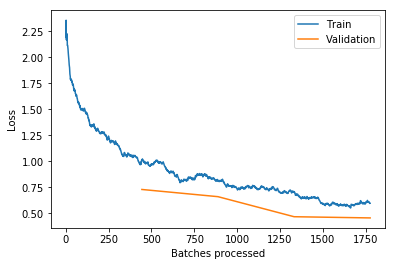

In [26]:
learn.recorder.plot_losses()

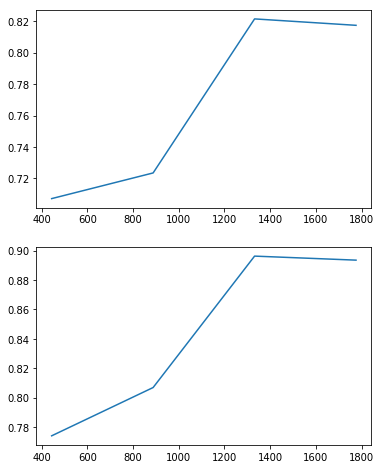

In [27]:
learn.recorder.plot_metrics()

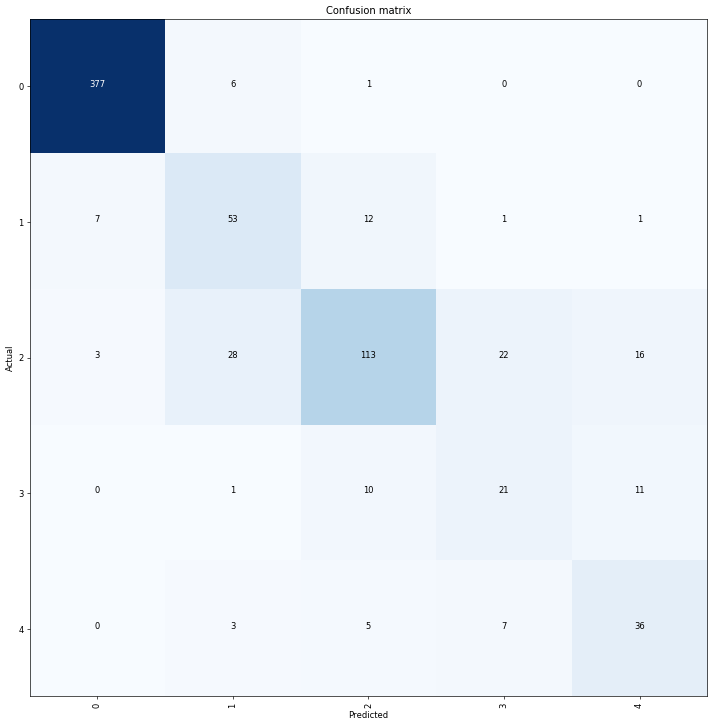

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [29]:
learn.save('stage-1-224')

In [30]:
learn.unfreeze()

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


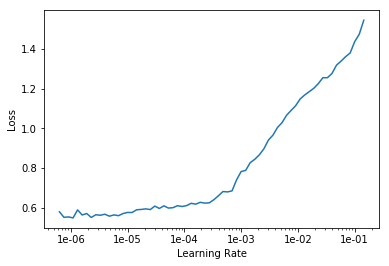

In [32]:
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.541310,0.450800,0.833787,0.896590
2,0.523405,0.430242,0.836512,0.897887
3,0.466641,0.455949,0.826975,0.894477
4,0.460940,0.446664,0.833787,0.899754


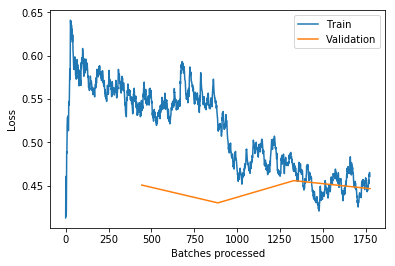

In [34]:
learn.recorder.plot_losses()

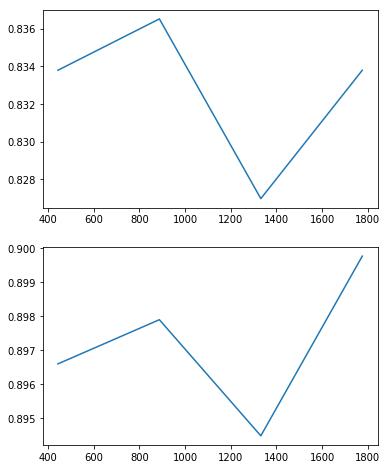

In [35]:
learn.recorder.plot_metrics()

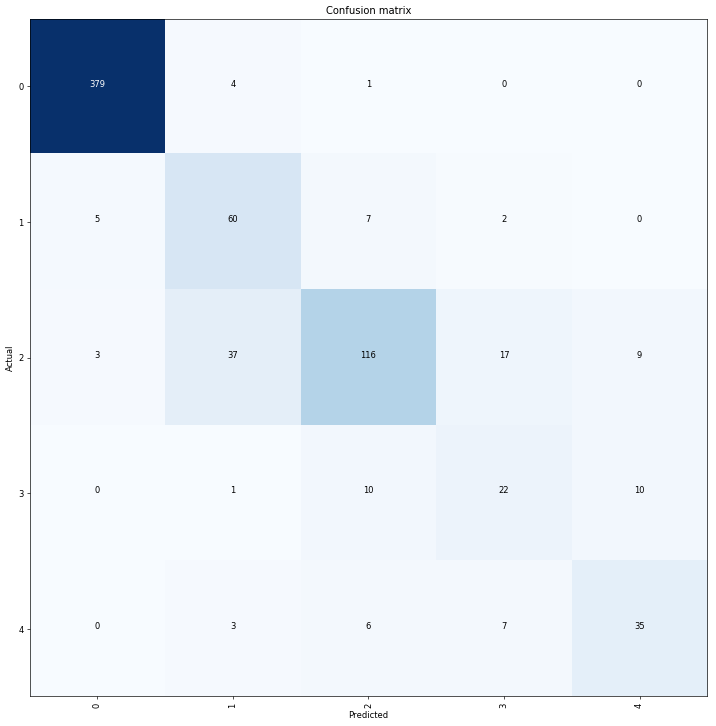

In [36]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [37]:
learn.save('stage-2-224')